In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 17.2 Data generation

In [2]:
n = 50
p_cr = 13 / 50
p_ch = 29 / 50
C_cr = st.binom.rvs(n = 50, p = p_cr, size = 1)
C_ch = st.binom.rvs(n = 50, p = p_ch, size = 1)
#C_cr = st.bernoulli.rvs(p = p_cr, size = 50).sum()
#C_ch = st.bernoulli.rvs(p = p_ch, size = 50).sum()
C = np.array([C_cr, C_ch]).reshape(-1)
species = ["Cross-leaved gentian","Chiltern gentian"]
idx = pd.factorize(species)[0]

### 17.4 Analysis using PyMC3

In [3]:
with pm.Model() as model_17_4:
    
    alpha = pm.Normal('alpha', 0, tau = 0.01)
    beta = pm.Normal('beta', 0, tau = 0.01)
    p = pm.Deterministic('p', pm.math.invlogit(alpha + beta * idx))
    C_pred = pm.Binomial('C_pred', n = 50, p = p, observed = C)
    
    # Derived quantities
    Occ_cross = pm.Deterministic('Occ_cross', pm.math.exp(alpha) / (1 + pm.math.exp(alpha)))
    Occ_chiltern = pm.Deterministic('Occ_chiltern', pm.math.exp(alpha + beta) / (1 + pm.math.exp(alpha + beta)))
    Occ_Diff = pm.Deterministic('Occ_Diff', Occ_chiltern - Occ_cross) 
    
    trace_17_4 = pm.sample(tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


In [4]:
az.summary(trace_17_4, var_names = ['~p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.314,0.370,-1.972,-0.626,0.015,0.011,580.0,822.0,1.0
beta,1.238,0.482,0.276,2.115,0.019,0.014,628.0,840.0,1.0
Occ_cross,0.218,0.061,0.115,0.336,0.003,0.002,580.0,822.0,1.0
Occ_chiltern,0.481,0.072,0.337,0.612,0.002,0.001,1557.0,1573.0,1.0
Occ_Diff,0.263,0.096,0.065,0.430,0.004,0.003,720.0,973.0,1.0


In [5]:
Occ_cross = trace_17_4.posterior.stack(samples = {'chain', 'draw'})['Occ_cross'].values.mean()
Occ_chiltern = trace_17_4.posterior.stack(samples = {'chain', 'draw'})['Occ_chiltern'].values.mean()

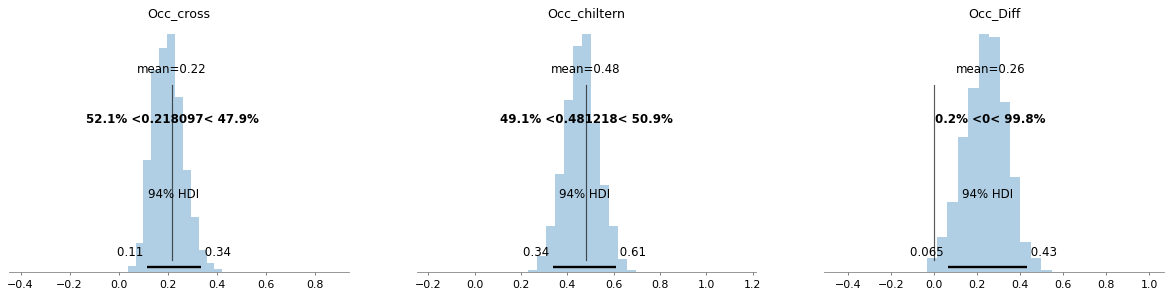

In [6]:
az.plot_posterior(trace_17_4, 
                  var_names = ['~p', '~alpha', '~beta'], 
                  ref_val = [Occ_cross, Occ_chiltern, 0],
                  ref_val_color = 'black',
                  kind = 'hist',
                  textsize = 11);

#### EXERCISES

**1.** *Binomial and Bernoulli*

In [7]:
n = 50
p_cr = 13 / 50
p_ch = 29 / 50
C_cr = st.bernoulli.rvs(p = p_cr, size = 50)
C_ch = st.bernoulli.rvs(p = p_ch, size = 50)
C = np.concatenate([C_cr, C_ch])
species = np.repeat(["Cross-leaved gentian","Chiltern gentian"], n)
idx = pd.factorize(species)[0]

In [8]:
with pm.Model() as model_17_4bernoulli:
    
    alpha = pm.Normal('alpha', 0, tau = 0.01)
    beta = pm.Normal('beta', 0, tau = 0.01)
    p = pm.Deterministic('p', pm.math.invlogit(alpha + beta * idx))
    C_pred = pm.Bernoulli('C_pred', p, observed = C)
    
    # Derived quantities
    Occ_cross = pm.Deterministic('Occ_cross', pm.math.exp(alpha) / (1 + pm.math.exp(alpha)))
    Occ_chiltern = pm.Deterministic('Occ_chiltern', pm.math.exp(alpha + beta) / (1 + pm.math.exp(alpha + beta)))
    Occ_Diff = pm.Deterministic('Occ_Diff', Occ_chiltern - Occ_cross) # Test quantity
    
    trace_17_4bernoulli = pm.sample(tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


In [9]:
az.summary(trace_17_4bernoulli, var_names = ['alpha', 'beta', 'Occ_cross', 'Occ_chiltern', 'Occ_Diff'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.865,0.314,-1.420,-0.293,0.011,0.008,819.0,1049.0,1.0
beta,1.035,0.424,0.245,1.795,0.015,0.010,848.0,969.0,1.0
Occ_cross,0.300,0.065,0.189,0.420,0.002,0.002,819.0,1049.0,1.0
Occ_chiltern,0.542,0.069,0.416,0.672,0.002,0.001,1395.0,1451.0,1.0
Occ_Diff,0.241,0.095,0.065,0.412,0.003,0.002,880.0,969.0,1.0
